In [1]:
import numpy as np

def normalizeV (v):
    return v / np.linalg.norm(v)
# https://stackoverflow.com/questions/23763796/how-to-find-slope-of-a-3d-plane
#
#  Z        Y
#  |      /
#  |    /
#  |  /
#  |/
#  ------------------------- X
#
def IsAPlane(heights, dist_between_px, angle_threshold):
    # p0 p1
    # p2 p3
    p0 = np.array([              0, dist_between_px, heights.item((0, 0))])
    p1 = np.array([dist_between_px, dist_between_px, heights.item((0, 1))])
    p2 = np.array([              0,               0, heights.item((1, 0))])
    p3 = np.array([dist_between_px,               0, heights.item((1, 1))])
    
    #print(p0, p1, p2, p3)
    
    # t1 = p0, p1, p3 
    # t2 = p0, p3, p2

    v32 = normalizeV(p3 - p2)    
    v12 = normalizeV(p1 - p2)
    v02 = normalizeV(p0 - p2)
    normal_2_1 = normalizeV(np.cross(v32, v12))
    normal_2_2 = normalizeV(np.cross(v12, v02))
    
    v13 = normalizeV(p1 - p3)
    v03 = normalizeV(p0 - p3)
    v23 = normalizeV(p2 - p3)
    normal_3_1 = normalizeV(np.cross(v13, v03))
    normal_3_2 = normalizeV(np.cross(v03, v23))
    
    # get horizontal vectors, not considering height difference
    n_test03 = p0 - p3
    n_test03[2] = 0
    n_test03 = normalizeV(n_test03)

    n_test12 = p1 - p2
    n_test12[2] = 0
    n_test12 = normalizeV(n_test12)
    
    # ~= 1.0 -> 0g
    cos_thresh = np.cos(angle_threshold * np.pi / 180.0)
    if (np.dot(normal_2_1, normal_2_2) > cos_thresh 
        and np.dot(normal_3_1, normal_3_2) > cos_thresh
        and np.dot(v03, n_test03) > cos_thresh
        and np.dot(v12, n_test12) > cos_thresh):
        return 1
    else:
        return 0
    
# receives a 200x200 matrix
def PlaneTest(win_heights):
    return IsAPlane(win_heights[99:101, 99:101], 120, 10)

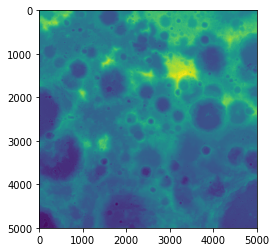

In [4]:
import math
import numpy as np
import sys
import cv2
import pickle
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

input_filename = "data/LAMP_80s_240mpp_ratio_albed_01.img"
shape = (2501, 2501) # matrix size
dtype = np.float32 # big-endian unsigned integer (16bit)
output_filename = "LAMP_BRITE.PNG"

height = np.reshape(np.fromfile(open("data/LDEM_75S_120M.IMG",
                                     'rb'), np.int16), (7624,7624))

height = height[1311:-1311,1311:-1311]
plt.imshow(height)
plt.show()

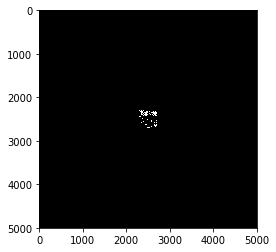

In [10]:
landing_pos = np.zeros((height.shape[0], height.shape[1]))

w = 400#height.shape[0] - 1
h = 400#height.shape[1] - 1
for i in range(w):
    for j in range(h):
        sub_set = height[2300 + i:2300 + i+2, 2300 + j:2300 + j+2]
        landing_pos[2300 + i, 2300 + j] = IsAPlane(sub_set, 120, 10)

plt.imshow(landing_pos, cmap = 'gray')
plt.show()

In [ ]:
%%time
from multiprocessing import Pool
from itertools import product

def process_isplane_round(params_tup):
    i, j = params_tup
    sub_set = height[i:i+2, j:j+2]
    return IsAPlane(sub_set, 120, 10), i, j

step = 1
x = (height.shape[0] - 1) // step
y = (height.shape[1] - 1) // step
params = product(np.arange(0, x), np.arange(0, y))
landing_pos_mt = np.zeros((height.shape[0], height.shape[1]))

with Pool(processes = 4) as p:
    results = p.map_async(process_isplane_round, params).get()
    for r in results:
        isplane, i, j = r
        landing_pos_mt[i, j] = isplane

plt.imshow(landing_pos_mt, cmap = 'gray')
plt.show()